## Imports:


In [392]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [367]:
import sys
import zipfile
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os
import math
import boto3
import s3fs
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot, dates
from datetime import timedelta
from prophet import Prophet
from pandas import read_csv
from pandas import datetime
from numpy import array
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import datetime as dttm
import statsmodels 
from statsmodels.tsa.arima.model import ARIMA

## Data configuration and readdings:


In [899]:
# Convert the sequence of seconds into datetime array
def parser(x):
    now_seconds = 0
    y = x.astype(np.float) + now_seconds
    z = pd.to_datetime(y, unit='s')
    return z

In [949]:
# Read the data from fname and eventually plot them
def read_data(fname, plot_data = False):
    # Read the time series
    datats = read_csv(fname, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

    headers = list(datats.columns.values)
    headers.insert(0, datats.index.name)

    # Resample the data using a uniform timestep
    datats = datats.resample('S').mean()
    datats = datats.interpolate(method='linear')
    # Convert data to numpy array
    data = datats.reset_index().values

    # Replace timestamps with seconds
    time_sec = array([data[i, 0].timestamp() for i in range(len(data))])
    data = np.c_[time_sec, data[:, 1:]]

    # Plot the pressure readings
    if (plot_data):
        pyplot.plot(data[:, 0], data[:, 1:8])
        pyplot.xlabel(headers[0])
        pyplot.ylabel('Pressure (bar)')
        # Use the original headers
        # headersplot = [w.replace('x_', '$x_') for w in headers[1:8]]
        # headersplot = [w.replace('}=', '}$=') for w in headersplot]
        # headersplot = [w.replace(' (bar)', '') for w in headersplot]
        # Use the headers p(x=xi)
        headersplot = [w[-8:-2] for w in headers[1:8]]
        px = ['$p(x_{%d}' % i for i in range(1, 8)]
        tail = [')$'] * 7
        headersplot = [px + headersplot + tail for px, headersplot, tail in zip(px, headersplot, tail)]
        pyplot.legend(headersplot)
        pyplot.title('Distributed pressure readings')
        pyplot.show(block=False)
        pyplot.savefig('pressure_readings.pdf')
    # some outliers and spikes
#     for i in random.sample(range(1, 3000), 100):
#         data[i][1:] = random.sample(range(1, 3000), 9)
        
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(data)
    scaler.scale_[0] = 1    # Do not normalize time

    # Apply the same normalization to all pressure readings
    pind = list(range(1, 8))  # Indices of pressure readings
    pmin = scaler.data_min_[pind].min()
    pmax = scaler.data_max_[pind].max()
    scaler.scale_[pind] = ((scaler.feature_range[1] - scaler.feature_range[0]) / (pmax - pmin))
    scaler.min_[pind] = scaler.feature_range[0] - pmin * scaler.scale_[pind]

    data = scaler.transform(data)

    return data, scaler

## Deploying Prophet:
### The riser data set:

In [969]:
data, scalar = read_data('riser_pq_uni.csv')
dft = pd.DataFrame.from_dict(dict(zip(['ds', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7','gas(m3/day)', 'liquid(m3/day)' ], data.T)))
trainSet = dft.iloc[:int(0.7*len(dft))]
testSet = dft.iloc[int(0.7*len(dft)):len(dft)]

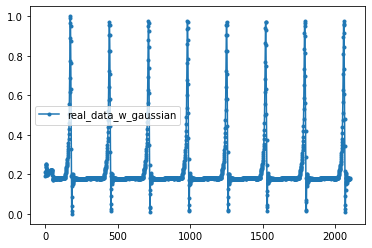

In [970]:
fig,ax = plt.subplots()
ax.plot(trainSet['ds'], trainSet['gas(m3/day)'], marker=".", label='real_data_w_gaussian')
ax.legend()

#### Adding gaussian noise:

In [971]:
trainSet = trainSet.set_index('ds')
mu, sigma = 0, 5e-3
noise = np.random.normal(mu, sigma, trainSet.shape) 

In [972]:
trainSet = trainSet + noise
trainSet = trainSet.reset_index()

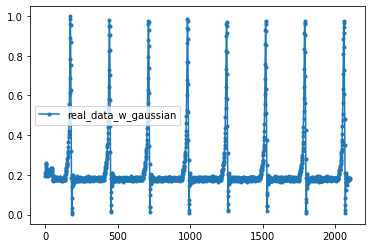

In [973]:
fig,ax = plt.subplots()
ax.plot(trainSet['ds'], trainSet['gas(m3/day)'], marker=".", label='real_data_w_gaussian')
ax.legend()

#### Removing some values: 

In [974]:
from random import randint
index = [randint(0, len(trainSet)) for i in range(100)]
trainSet.iloc[index,[1,2,3,4,5,6, 7, 8, 9]] = 0

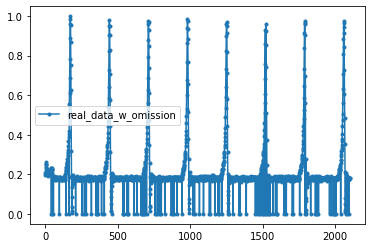

In [975]:
fig,ax = plt.subplots()
ax.plot(trainSet['ds'], trainSet['gas(m3/day)'], marker=".", label='real_data_w_omission')
ax.legend()

##### Adding Outliers:

In [804]:
from random import randint
index = [randint(0, len(trainSet)) for i in range(10)]
for i in range(10):
    trainSet.iloc[index,[1,2,3,4,5,6, 7, 8, 9]] = random.sample(range(1, 1000), 9)

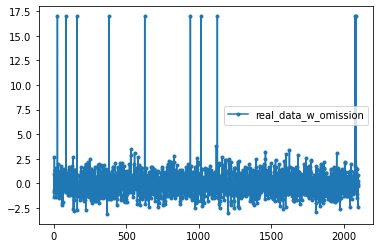

In [805]:
# fig,ax = plt.subplots()
# ax.plot(trainSet['ds'], trainSet['gas(m3/day)'], marker=".", label='real_data_w_omission')
# ax.legend()

#### Finding the best parameters for this application:

In [ ]:
import itertools
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

from prophet.diagnostics import cross_validation, performance_metrics
# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).add_regressor('p1').add_regressor('p2').add_regressor('p3').add_regressor('p4')\
                         .add_regressor('p5').add_regressor('p6').add_regressor('p7').fit(train_set)  # Fit model with given params
    print("fitting-Done")
    df_cv = cross_validation(m,horizon='5 minutes', parallel="processes")
    print("cross_validation-Done")
    df_p = performance_metrics(df_cv, rolling_window=1)
    print('finding_RMSE-Done')
    rmses.append(df_p['rmse'].values[0])
    
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

##### Applying:

In [976]:
rme = []
for i in range(0,2):
    train_set = trainSet
    test_set = testSet
    if i == 0:
        train_set = train_set.rename(columns={'gas(m3/day)':'y'})
        test_set = test_set.rename(columns={'gas(m3/day)':'y'})
    else:
        train_set = train_set.rename(columns={'y':'gas','liquid(m3/day)':'y'})
        test_set = test_set.rename(columns={'y':'gas','liquid(m3/day)':'y'})
    prop = Prophet(daily_seasonality=True,changepoint_prior_scale=0.01, seasonality_prior_scale=10.0)
    prop.add_regressor('p1')
    prop.add_regressor('p2')
    prop.add_regressor('p3')
    prop.add_regressor('p4')
    prop.add_regressor('p5')
    prop.add_regressor('p6')
    prop.add_regressor('p7')
    prop.fit(train_set)
    forecast = prop.predict(test_set.drop(columns="y"))
    rme.append(mean_squared_error(test_set['y'], forecast['yhat']))
    

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [977]:
rme

[0.011950121239730787, 0.010777166549528275]

In [978]:
forecast = prop.predict(test_set.drop(columns="y"))

In [979]:
forecast['ds'] = range(2100, 3001)

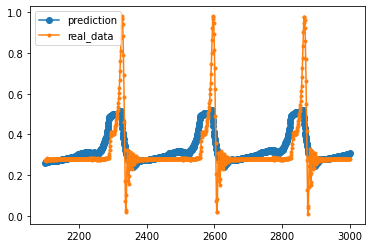

In [980]:
fig,ax = plt.subplots()
ax.plot(forecast['ds'], forecast['yhat'], marker="o", label='prediction')
ax.plot(test_set['ds'], test_set['y'], marker=".", label='real_data')
ax.legend(loc='upper left')

### The Well dataset:


In [981]:
def read_data(fname, plot_data = False):
    # Read the time series
    datats = read_csv(fname, header=0, dayfirst=True, parse_dates=[0], index_col=0, squeeze=True)  # , date_parser=parser

    headers = list(datats.columns.values)
    headers.insert(0, datats.index.name)

    # Convert data to numpy array
    data = datats.reset_index().values

    # Split data into flow periods, and resample each flow period using a uniform timestep
    dt = np.ediff1d(data[:, 0])
    fpbreak = dttm.timedelta(hours=1)  # Minimal break between flow periods
    dt = dt - fpbreak
    ind = np.where(dt - fpbreak > pd.Timedelta(0))[0]
    ind = np.r_[ind, len(data)-1]

    Nfp = len(ind)  # Number of flow periods
    fp = ['None'] * Nfp
    n0 = 0
    n1 = ind[0]+1
    for n in range(Nfp):
        # Resample each flow period separately
        fpts = datats[n0:n1].resample('T').mean()
        fpts = fpts.interpolate(method='linear')
        # Save the resampled flow period to a list of numpy arrays
        fp[n] = fpts.reset_index().values
        #fp[n] = data[n0:n1,:]
        n0 = n1
        if n+1 < Nfp:
            n1 = ind[n+1] + 1
    # some outliers and spikes
#     for i in random.sample(range(1, 3000), 100):
#         data[i][1:] = random.sample(range(1, 3000), 5)

    # Get the normalization parameters for all data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(data[:,1:]) # Exclude Datetime from normalization

    # Normalize every flow period
    for n in range(Nfp):
        fp[n][:,1:] = scaler.transform(fp[n][:,1:])

    return fp, headers, scaler
#     return fp, headers




In [982]:
fp,headers, scaler = read_data('welltest.csv')

##### Whole day training:

In [983]:
df = pd.DataFrame.from_dict(dict(zip(headers, fp[0].T)))
for i in [1,2,3]:
    tmp = pd.DataFrame.from_dict(dict(zip(headers, fp[i].T)))
    df = pd.concat([df,tmp], axis=0)
df = df.rename(columns={'DateTime':'ds'})
train = df
test = pd.DataFrame.from_dict(dict(zip(headers, fp[4].T)))
test = test.rename(columns={'DateTime':'ds'})

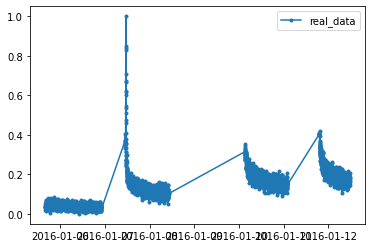

In [984]:
fig,ax = plt.subplots()
ax.plot(df['ds'], df['Qo (m3/day)'], marker=".", label='real_data')
ax.legend()

##### part of day training:

In [930]:
df = pd.DataFrame.from_dict(dict(zip(headers, fp[0].T)))
df = df.rename(columns={'DateTime':'ds'})
train = df.iloc[:int(0.7*len(df))]
test = df.iloc[int(0.7*len(df)):len(df)]

#### Adding gaussian noise:

In [985]:
train = train.set_index('ds')
mu, sigma = 0, 1e-3 #1
noise = np.random.normal(mu, sigma, train.shape) 

In [986]:
train = train + noise
train = train.reset_index()

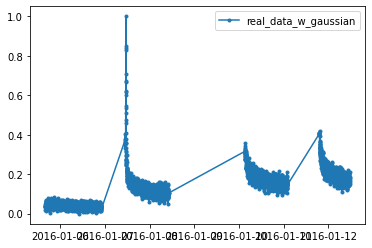

In [987]:
fig,ax = plt.subplots()
ax.plot(train['ds'], train['Qo (m3/day)'], marker=".", label='real_data_w_gaussian')
ax.legend()

#### Removing some data:

In [988]:
from random import randint
index = [randint(0, len(train)) for i in range(100)]
train.iloc[index,[1,2,3,4,5]] = 0

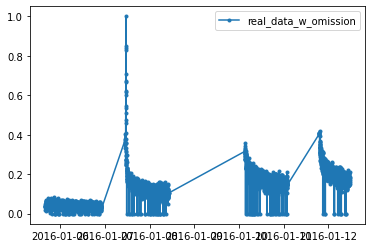

In [989]:
fig,ax = plt.subplots()
ax.plot(train['ds'], train['Qo (m3/day)'], marker=".", label='real_data_w_omission')
ax.legend()

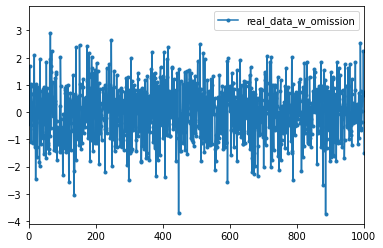

In [891]:
fig,ax = plt.subplots()
ax.plot(train['Qo (m3/day)'], marker=".", label='real_data_w_omission')
ax.set_xlim([0, 1000])
ax.legend()

##### Applying:

In [990]:
rme = []
for i in range(0,3):
    trainSet = train
    testSet = test
    if i == 0:
        trainSet = trainSet.rename(columns={'Qo (m3/day)':'y'})
        testSet = testSet.rename(columns={'Qo (m3/day)':'y'})
    if i == 1:
        trainSet = trainSet.rename(columns={'Qw (m3/day)':'y'})
        testSet = testSet.rename(columns={'Qw (m3/day)':'y'})
    if i == 2:
        trainSet = trainSet.rename(columns={'Qg (m3/day)':'y'})
        testSet = testSet.rename(columns={'Qg (m3/day)':'y'})
    m = Prophet( daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True, changepoint_prior_scale=0.001, seasonality_prior_scale=0.1, \
                 holidays_prior_scale=10.0, seasonality_mode='multiplicative')
    m.add_regressor('Pressure (bar)')
    m.add_regressor('Temperature (degC)')
    m.fit(trainSet)
    forecast = m.predict(testSet.drop(columns="y"))
    rme.append(mean_squared_error(testSet['y'], forecast['yhat']))
    if i ==0:
        oil_train = m.predict(trainSet.drop(columns="y"))
        oil = m.predict(testSet.drop(columns="y"))
    if i ==1:
        water_train = m.predict(trainSet.drop(columns="y"))
        water = m.predict(testSet.drop(columns="y"))
    if i ==2:
        gas_train = m.predict(trainSet.drop(columns="y"))
        gas = m.predict(testSet.drop(columns="y"))

In [991]:
prediction_oil = pd.concat([oil_train, oil], axis=0)
prediction_water = pd.concat([water_train,water], axis=0)
prediction_gas = pd.concat([gas_train, gas], axis=0)
prediction = pd.concat([prediction_oil['yhat'], prediction_water['yhat'], prediction_gas['yhat']], axis=1)
dft = pd.concat([train, test], axis=0)
dft = dft.iloc[:, 1:3]
forecast_set = pd.concat([dft, prediction], axis=1)
inverse = scaler.inverse_transform(forecast_set)

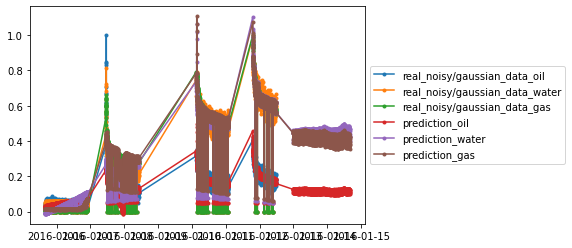

In [992]:
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fig,ax = plt.subplots()
ax.plot(train['ds'], train['Qo (m3/day)'], marker=".", label='real_noisy/gaussian_data_oil')
ax.plot(train['ds'], train['Qw (m3/day)'], marker=".", label='real_noisy/gaussian_data_water')
ax.plot(train['ds'], train['Qg (m3/day)'], marker=".", label='real_noisy/gaussian_data_gas')
ax.plot(prediction_oil['ds'], prediction_oil['yhat'], marker=".", label='prediction_oil')
ax.plot(prediction_water['ds'], prediction_water['yhat'], marker=".", label='prediction_water')
ax.plot(prediction_gas['ds'], prediction_gas['yhat'], marker=".", label='prediction_gas')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

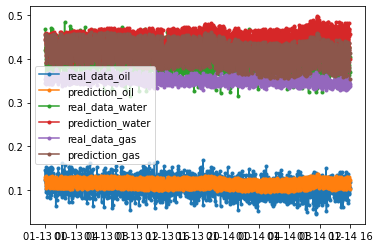

In [993]:
fig,ax = plt.subplots()
ax.plot(test['ds'], test['Qo (m3/day)'], marker=".", label='real_data_oil')
ax.plot(oil['ds'], oil['yhat'], marker=".", label='prediction_oil')
ax.plot(test['ds'], test['Qw (m3/day)'], marker=".", label='real_data_water')
ax.plot(water['ds'], water['yhat'], marker=".", label='prediction_water')
ax.plot(test['ds'], test['Qg (m3/day)'], marker=".", label='real_data_gas')
ax.plot(gas['ds'], gas['yhat'], marker=".", label='prediction_gas')
ax.legend()

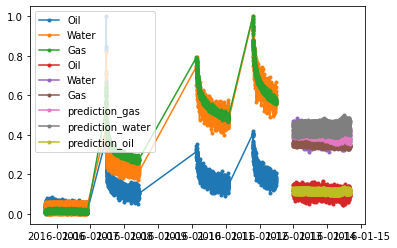

In [994]:
fig,ax = plt.subplots()
ax.plot(df['ds'], df['Qo (m3/day)'], marker=".", label='Oil')
ax.plot(df['ds'], df['Qw (m3/day)'], marker=".", label='Water')
ax.plot(df['ds'], df['Qg (m3/day)'], marker=".", label='Gas')
ax.plot(test['ds'], test['Qo (m3/day)'], marker=".", label='Oil')
ax.plot(test['ds'], test['Qw (m3/day)'], marker=".", label='Water')
ax.plot(test['ds'], test['Qg (m3/day)'], marker=".", label='Gas')
ax.plot(gas['ds'], gas['yhat'], marker=".", label='prediction_gas')
ax.plot(water['ds'], water['yhat'], marker=".", label='prediction_water')
ax.plot(oil['ds'], oil['yhat'], marker=".", label='prediction_oil')
ax.legend()

## Finding the best parameters

In [747]:
import itertools
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 5.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 5.0, 10.0],
    'seasonality_mode': ['multiplicative', 'additive'],
    'daily_seasonality': [True, False], 
    'weekly_seasonality': [True, False],
    'yearly_seasonality': [True, False]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# rmses = []  # Store the RMSEs for each params here


In [751]:
from prophet.diagnostics import cross_validation, performance_metrics
# Use cross validation to evaluate all parameters
rmse_Oil = []
rmse_Water = []
rmse_Gas = []
for params in all_params:
    for i in range(0,3):
        trainSet = train
        testSet = test
        if i == 0:
            trainSet = trainSet.rename(columns={'Qo (m3/day)':'y'})
            testSet = testSet.rename(columns={'Qo (m3/day)':'y'})
        if i == 1:
            trainSet = trainSet.rename(columns={'Qw (m3/day)':'y'})
            testSet = testSet.rename(columns={'Qw (m3/day)':'y'})
        if i == 2:
            trainSet = trainSet.rename(columns={'Qg (m3/day)':'y'})
            testSet = testSet.rename(columns={'Qg (m3/day)':'y'})
        m = Prophet(**params).add_regressor('Pressure (bar)').add_regressor('Temperature (degC)').fit(trainSet)  # Fit model with given params
        df_cv = cross_validation(m,horizon='1 days', initial='4 days', parallel="processes")
        df_p = performance_metrics(df_cv, rolling_window=1)
        if i == 0:
            rmse_Oil.append(df_p['rmse'].values[0])
        if i == 1:
            rmse_Water.append(df_p['rmse'].values[0])
        if i == 2:
            rmse_Gas.append(df_p['rmse'].values[0])

INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa7214cae50>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa71d091bd0>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa7225aaa50>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa72265ef90>
INFO:prophet:Ski

INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa71d085c90>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa722f9fa10>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa7209b9f10>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExe

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa71c292b10>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa722b65710>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa71e77d6d0>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa7223aa210>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 0

INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa70e0ea590>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa71fd69bd0>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa720232fd0>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa7209c6bd0>
INFO:prophet:Ski

INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa72238a7d0>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa7214b7710>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa722398350>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExe

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa71fd69b10>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa722380750>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa71d16bcd0>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa71d178990>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 0

INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa71d0b7990>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa71bd64c10>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa7237af850>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa71a48dc50>
INFO:prophet:Ski

INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa722b65350>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa7214c5cd0>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa71d9630d0>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExe

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa71d1b8210>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa7225cfbd0>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa72009d710>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa7209b9dd0>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 0

INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa7223aa050>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa723fc3b90>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa7214b7710>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa720232fd0>
INFO:prophet:Ski

INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa707dcffd0>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa723ead890>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa7069e1ed0>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExe

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa722f9fa10>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa71c97d6d0>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa7209b9f10>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa7214b7710>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 0

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa7214b3f10>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa722179d10>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa723d03dd0>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa71ba51950>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 0

INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa71d0b7490>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa72265ef90>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa72231ad10>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa70d836ad0>
INFO:prophet:Ski

INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa71d0c5a50>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa72008f7d0>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa722398350>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExe

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa707dcffd0>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa722300190>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa722f9fed0>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa723d0bf10>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 0

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa7069e1ed0>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa707c1c810>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa7237b0e90>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa712b54890>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 0

INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa721523790>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa722a35590>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa720232b50>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa723a54bd0>
INFO:prophet:Ski

INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa7214b3b50>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa71ee57490>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa72322cd10>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExe

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa72238a7d0>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa70d589dd0>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa71d085c90>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa721523790>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 0

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa72265ef90>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa722283d90>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa720103710>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa71d1d3450>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 0

INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa7214c5cd0>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa720227e50>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa721532b90>
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2016-01-10 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa70bc25290>
INFO:prophet:Ski

KeyboardInterrupt: 

In [756]:
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmseOil'] = rmse_Oil + [0 for i in range(len(tuning_results)-len(rmse_Oil))]
tuning_results['rmseWater'] = rmse_Water + [0 for i in range(len(tuning_results)-len(rmse_Oil))]
tuning_results['rmseGas'] = rmse_Gas + [0 for i in range(len(tuning_results)-len(rmse_Oil))]

In [757]:
tuning_results['avg_rmse'] = tuning_results.loc[:, 'rmseOil':'rmseGas'].mean(axis=1)

In [887]:
tuning_results.iloc[0:168].min(axis=0)

changepoint_prior_scale       0.001
seasonality_prior_scale        0.01
holidays_prior_scale           0.01
seasonality_mode           additive
daily_seasonality             False
weekly_seasonality            False
yearly_seasonality            False
rmseOil                    0.975961
rmseWater                  1.038272
rmseGas                    1.031606
avg_rmse                   1.025532
dtype: object

In [888]:
a = tuning_results.iloc[0:168] 
len(a)

168

In [889]:
a[a['avg_rmse']<1.03]

,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,daily_seasonality,weekly_seasonality,yearly_seasonality,rmseOil,rmseWater,rmseGas,avg_rmse
49,0.001,0.01,5.00,multiplicative,True,True,False,0.975961,1.057408,1.049806,1.027725
82,0.001,0.10,0.01,multiplicative,True,False,True,1.001179,1.039463,1.045168,1.028603
86,0.001,0.10,0.01,multiplicative,False,False,True,1.000988,1.041415,1.042945,1.028449
98,0.001,0.10,0.10,multiplicative,True,False,True,1.001756,1.039828,1.045941,1.029175
99,0.001,0.10,0.10,multiplicative,True,False,False,0.976642,1.063845,1.048141,1.029543
102,0.001,0.10,0.10,multiplicative,False,False,True,1.001176,1.041337,1.039907,1.027473
114,0.001,0.10,1.00,multiplicative,True,False,True,1.001514,1.039358,1.047446,1.029439
118,0.001,0.10,1.00,multiplicative,False,False,True,1.000666,1.040898,1.035033,1.025532
130,0.001,0.10,5.00,multiplicative,True,False,True,1.001710,1.039334,1.047826,1.029623
134,0.001,0.10,5.00,multiplicative,False,False,True,1.000789,1.040943,1.035025,1.025586
